In [1]:
# Notebook configuration for plotting
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['figure.figsize'] = (18.0, 10.0)

COLORS = [(0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 (0.2823529411764706, 0.47058823529411764, 0.8117647058823529),
 (0.41568627450980394, 0.8, 0.396078431372549),
 (0.7058823529411765, 0.48627450980392156, 0.7803921568627451),
 (0.7686274509803922, 0.6784313725490196, 0.4),
 (0.4666666666666667, 0.7450980392156863, 0.8588235294117647)]
plt.rcParams['axes.prop_cycle'] = plt.cycler('color', COLORS)

In [2]:
# Some libraries we'll use in what follows
import numpy as np
import pandas as pd

# "Introduction to machine learning" Workshop

Welcome to the machine learning workshop!


# What's machine learning ?

Machine Learning is about building (statistical) models that improve as they learn from existing data. These models can solve a variety of issues, but the most common are supervised learning problems for **classification** and **prediction** tasks (other tasks include: clustering, generating data, ...)

Machine learning can be divided into two main categories: supervised learning and unsupervised learning.

### Supervised Learning

In **Supervised Learning**, we have a dataset consisting of both features and the expected output values (labels).
The task is to train a model that is able to predict the label of an object
given its features. For example, predicting if someone has the flu based on physiological measurements.

Some more complicated examples are:

- given a photograph of a person, identify the person in the photo.
- given the list of songs a user listened to, recommend a song they would like
  (we call this a *recommender system*, something we're actively working on at Spotify).

In the case of **classification**, the labels are discrete (usually strings or a limited number of integers). For example: identifying which species is on a photograph.
In the case of **regression**, the labels are continuous (usually floats or vectors of floats). For example: predicting the weight of a person based on her diet.

### Unsupervised Learning

In **Unsupervised Learning**, there data points are not labeled and the task is usually to detect some fundamental structure present in the data: data points that could be grouped together, correlated dimensions, etc.

Examples of **unsupervised learning** tasks are:

- clustering politicians based on their voting history
- finding topics discussed in the aftonbladet
- decomposing an electrical signal into the sub-signals that compose it


# What will we do in this workshop?

We'll focus on **supervised learning** with a classification task.

We're going to use data donated by the University of California, Irvine, about cancer diagnostics.

The data consists of 32 columns:

1. ID number 
2. Diagnosis (M = malignant, B = benign) 
3. (to 32)
    Ten real-valued features are computed for each cell nucleus: 

    - radius (mean of distances from center to points on the perimeter) 
    - texture (standard deviation of gray-scale values) 
    - perimeter 
    - area 
    - smoothness (local variation in radius lengths) 
    - compactness (perimeter^2 / area - 1.0) 
    - concavity (severity of concave portions of the contour) 
    - concave points (number of concave portions of the contour) 
    - symmetry 
    - fractal dimension ("coastline approximation" - 1)

# Part I: Data loading and exploration

## * 1) Loading the data

We'll try to load the data directly from the UCI website. Theirs servers have been in a pretty bad shape recently, returning a lot of server errors, so we also have a local copy of the data.

We'll use `pandas` to load this data:

In [3]:
# The dataset doesn't contain a header containing column names
# so we generate them ourselves.
feature_columns = ['feature_{}'.format(i) for i in range(1, 31)]
columns = ['id', 'diagnosis'] + feature_columns

# Reading data from a 
#DATA_PATH = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data'
DATA_PATH = 'wdbc.data'
df = pd.read_csv(DATA_PATH, header=None, names=columns, index_col='id')
df['diagnosis'] = df['diagnosis'].astype('category')

Well, that was easier than expected, right?

## * 2) Exploring the data

Randomly feeding your data into the the newest and most "hip" model (_"RSNMIN: Recurrent Stochastic Neural Machine Implemented in Node.js"_) is the worst you could do at this point.

You should first try to explore your data and have a feel of how it's distributed, if there are any values missing, any special correlations, etc. Only after having all this information will you be able to choose the right model(s) and pre-processing to use.

Let's start by looking at how our data is distributed:

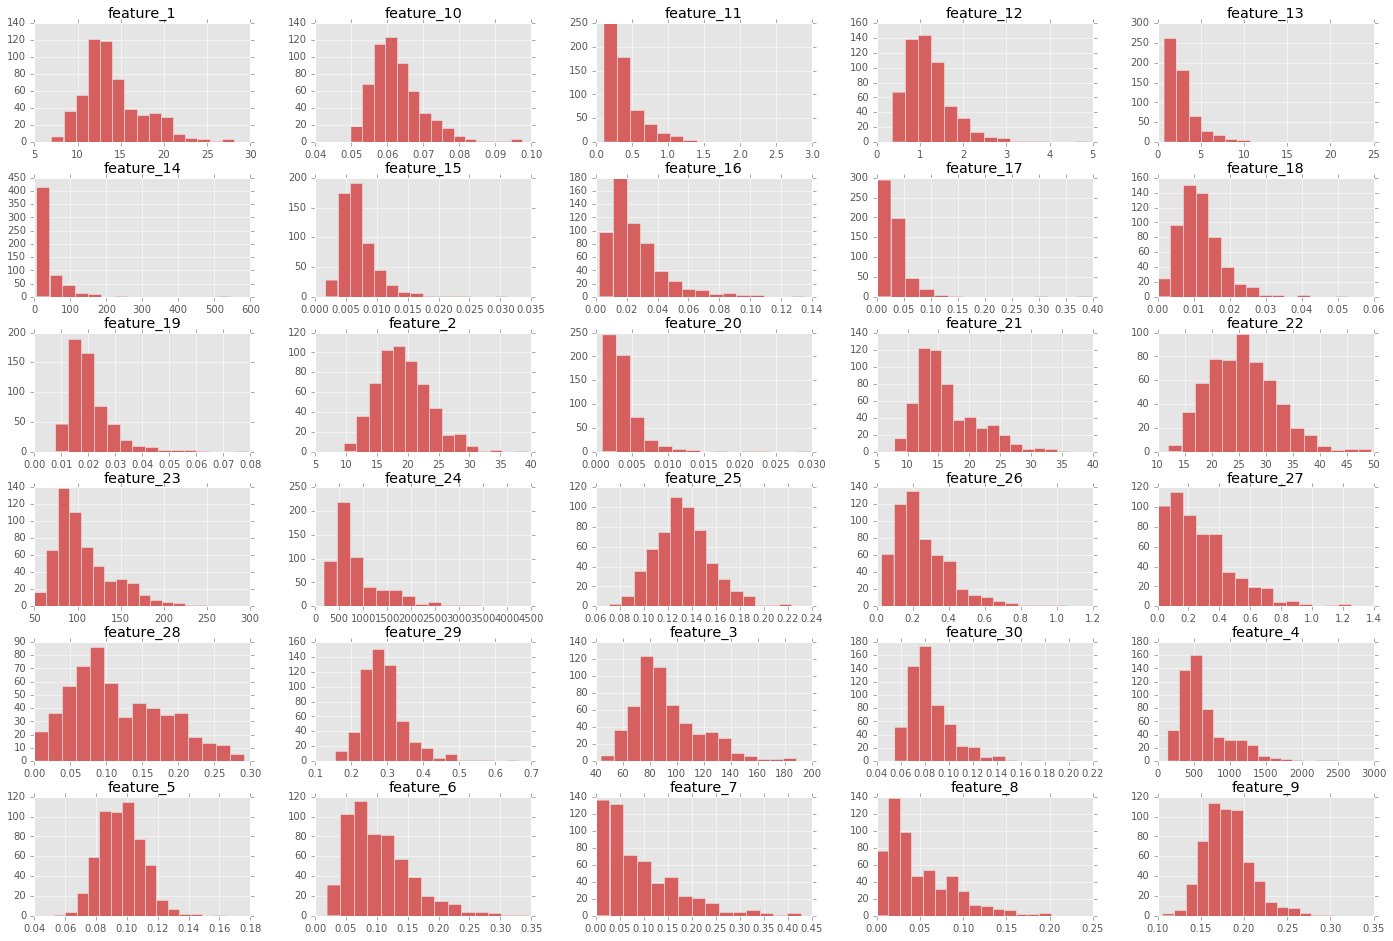

In [4]:
_ = df.hist(bins=15, figsize=(24, 16))

Most of the features seem to follow a gaussian distributions. Perfect! This is usually how you'd like your data to be distributed.

Uniformly distributed data and greatly skewed distributions can be painful to deal with, as they might not provide as much information to your models.

What we did just now is called **univariate distributions**: how every variable is distributed independantly of the others. Let's try to look at some **multivariate distributions**, and to be more precise: bi-variate distributions.

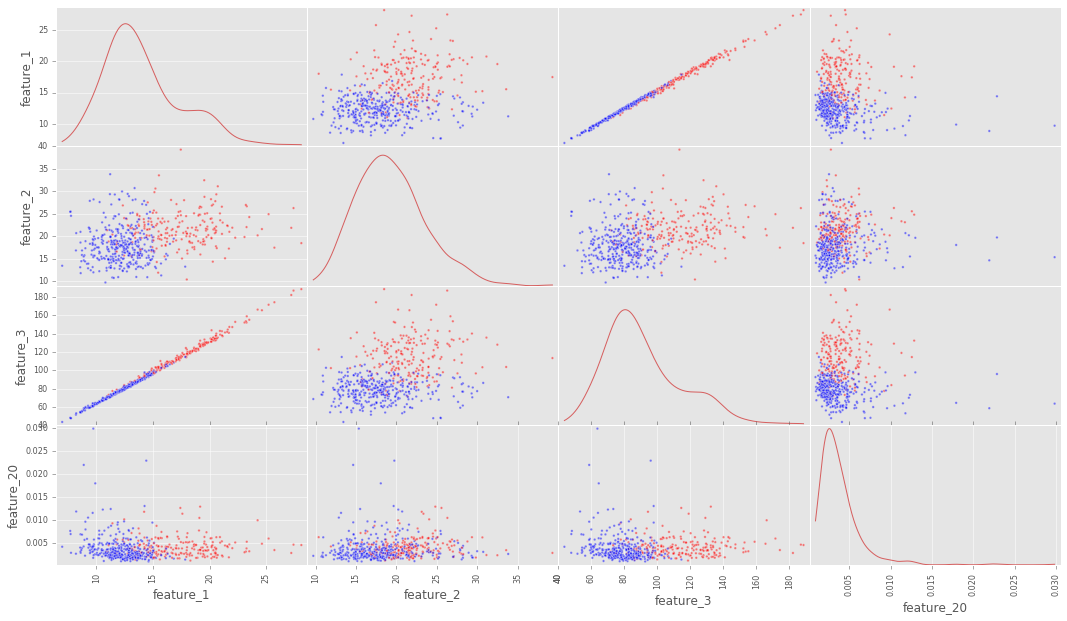

In [5]:
from pandas.tools.plotting import scatter_matrix
label_colors = ['b' if d == 'B' else 'r' for d in df['diagnosis']]
_ = scatter_matrix(df[['feature_1', 'feature_2', 'feature_3', 'feature_20']], c=label_colors, diagonal='kde', s=25)

We have 3 observations to make here:

- Correlated variables: It's pretty obvious that **`feature_1`** and **`feature_3`** are highly correlated.
- Like we saw in the previous plot, **`feature_20`** is highly skewed towards lower values, with some outliers in a higher range.
- The other variables are not particularly correlated.

Correlated variables can have a big impact on the performance of our models. Some models are highly sensitive to them and work best with independant variables (like `Naive Bayes`) while others won't be affected as much by these correlations (like `Logistic Regression`, thanks to the regularization term that will *eliminate* variables that do not contribute anything new).

To get a more formal view of how our variables are correlated, we can calculate a "correlation" matrix using metrics like the `Pearson correlation`: the higher the absolute value of this metric is, the more the variables are correlated.

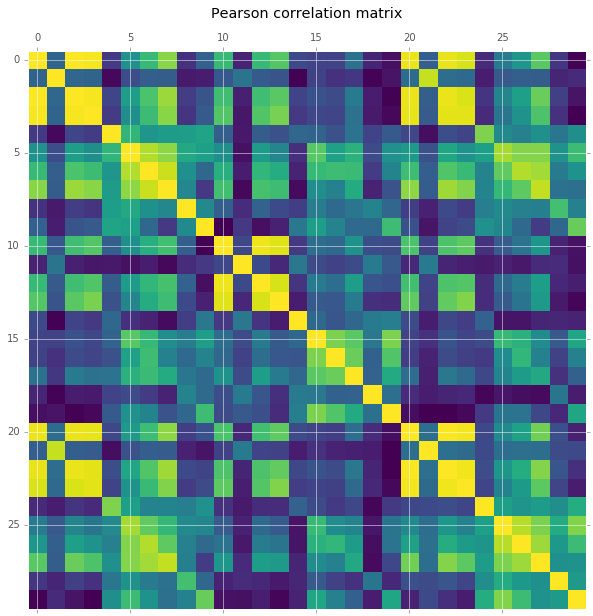

In [6]:
correlation_matrix = np.corrcoef(df[feature_columns].values.T)
plt.matshow(np.abs(correlation_matrix))
plt.title('Pearson correlation matrix')

From looking at these matrices, we can see that a strong correlation exists between some features of the first molecule and the equivalent features in the third one. We can confirm this by extracting strongly correlated features and visualizing them:

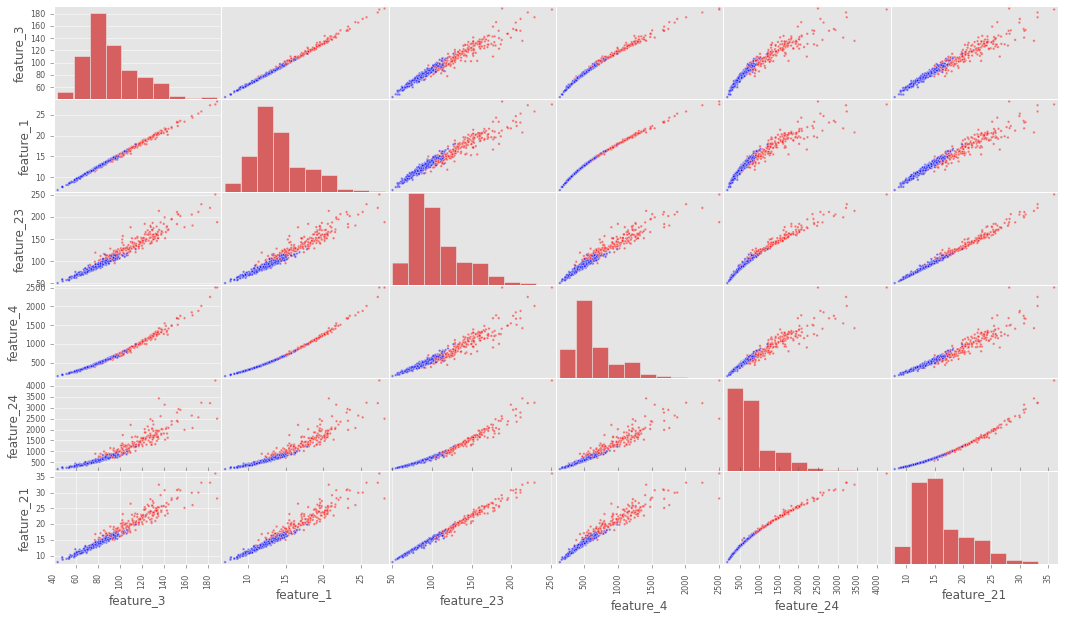

In [7]:
import itertools
strongly_correlated_couples = [(feature_columns[i], feature_columns[j]) for i in range(30) for j in range(i+1, 30)
                               if abs(correlation_matrix[i, j]) >= 0.98] 
strongly_correlated_features = list(set(feature for f_couple in strongly_correlated_couples for feature in f_couple))

_ = scatter_matrix(df[strongly_correlated_features], c=label_colors, s=25)

# Part II: The *actual* machine learning
(aka, building models!)

## Model choice and pre-processing


Now that we have a better idea of what our data looks like, we can start the modelling part.

Depending on what models we use and the distribution of the data, it can be a good idea to do some "feature engineering" and do some pre-processing on the features.

Some common pre-processing operations:
- Normalizing the data: Centering the component around 0 with a standard deviation of 1.
- Scaling the data: Making sure all values of the component are comprised between certain minimum and maximum values.
- Feature selection: It might be good to drop some features if they have a negative impact on the performance of the model.
- Dimensionality reduction: If we have a very high number of features, including many that are highly correlated, it's a good idea to reduce the number of components by keeping the maximum amount of information.

Some models perform better if the data is normalized (Support Vector Machines, some Neural Networks), others are sensitive to correlated features (Naive Bayes). Depending on the model you choose, some pre-processing steps might improve or worsen performance. So choose wisely!

## Evaluation

This is usually seen as the last step you take to check everything is working correctly once you've built your model... but really, it's more of a feedback loop than a sequential process!

Many models require **hyper-parameters** which you have to tune based on the performance of your model. It is (sometimes) possible to choose a sensible value for a hyper-parameter based on the nature of the data, but it's most likely that you'll just have to try a large number of values until you find those that work best for your data... and you need to do **model evaluation** for that!

## Which library to use?

The clear leader in this field is **`scikit-learn`**: this is the most popular machine learning library in Python and is by itself enough of a reason to use Python instead of something like Java. It's under active developement, contains tons of models and tools to do feature engineering / pre-processing / visualize data. It's great!

## 1) A first simple model

It's often good to start with the simplest model [(occam's razor!)](https://en.wikipedia.org/wiki/Occam%27s_razor), so let's do a simple **Logistic Regression**: this model is usually used for binary classification tasks but can be extended for multi-class classifications. **`scikit-learn`** makes it super easy to use a model:

In [9]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.cross_validation import train_test_split

all_features = df[feature_columns].values
labels = df['diagnosis'].values.to_dense()

model = LogisticRegressionCV()

X_train, X_test, y_train, y_test = train_test_split(all_features, labels, train_size=0.33, random_state=42)

model.fit(X_train, y_train)

model.predict(X_test)

array(['B', 'M', 'M', 'B', 'B', 'M', 'M', 'M', 'B', 'B', 'B', 'M', 'B',
       'M', 'B', 'M', 'B', 'B', 'B', 'M', 'B', 'B', 'M', 'B', 'B', 'B',
       'B', 'B', 'B', 'M', 'B', 'B', 'B', 'B', 'B', 'B', 'M', 'B', 'M',
       'B', 'B', 'M', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'M', 'M',
       'B', 'B', 'B', 'B', 'B', 'M', 'M', 'B', 'B', 'M', 'M', 'B', 'B',
       'B', 'M', 'M', 'B', 'B', 'M', 'M', 'B', 'M', 'B', 'B', 'B', 'B',
       'B', 'B', 'M', 'B', 'B', 'M', 'M', 'M', 'M', 'M', 'B', 'B', 'B',
       'B', 'B', 'B', 'B', 'B', 'M', 'M', 'B', 'M', 'M', 'B', 'M', 'M',
       'B', 'B', 'B', 'M', 'B', 'B', 'M', 'B', 'M', 'M', 'B', 'M', 'B',
       'B', 'B', 'M', 'B', 'B', 'B', 'M', 'B', 'M', 'M', 'B', 'B', 'M',
       'M', 'M', 'B', 'B', 'B', 'M', 'B', 'B', 'B', 'M', 'B', 'M', 'B',
       'B', 'M', 'B', 'M', 'M', 'M', 'B', 'M', 'B', 'B', 'B', 'B', 'M',
       'M', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'M', 'B', 'B', 'B', 'B',
       'M', 'B', 'B', 'B', 'B', 'B', 'B', 'M', 'B', 'B', 'B', 'B

Awesome!

What we've done here is:

1. Initialize the `LogisticRegressionCV` class (if you want to use a different model, just initialize a different class)
2. Split the data into training and test data. This is **very** important: if you train and test your models on the same data, you'll tend to optimize towards an unrealistic case. What you're trying to do is classify data **you've never seen before**.
3. We predict the class of the training test.

That's cool and all, but how can we know if our model performs well? Well, **`scikit-learn`** has a set of tools specifically dedicated to this task, and they're pretty easy to use:

In [10]:
from sklearn.cross_validation import cross_val_score
cross_val_score(model, all_features, labels, cv=8, scoring='accuracy')

array([ 0.97222222,  0.90277778,  0.93055556,  0.94444444,  1.        ,
        0.95714286,  0.92857143,  0.97142857])

Every value is the metric we chose (`accuracy` in this case) for every split of the data.

It's important to choose the right metric for evaluation, because depending on what you're trying to do you'll want to optimize for different things.

For instance, maybe it's OK to make a False Positive (predicting a `benign` cancer as being `malignant`), but it's super dangerous to do False Negatives (predicting a `malignant` cancer as being `benign`). And maybe you're doing fraud detection and you want to minimize the number of False Positives because every one of them costs you a lot of money to investigate.

Now that we know how to evaluate a model, let's try to look at something a bit more complex: how to pick the right variables for our model?

## 2) Feature selection

There's many ways to do feature selection: based on the variance of the data, based on its contribution to the model, etc.

We'll use "recursive feature elimination" to see pick the right features for our model, this time a **Support Vector Machine**:

Optimal number of features : 17


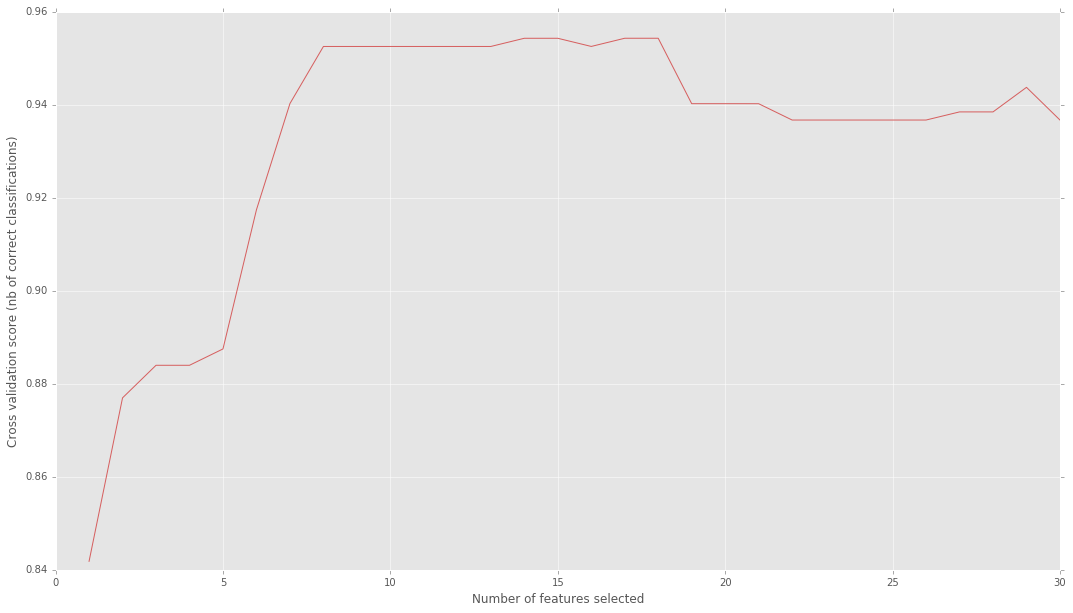

In [11]:
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV
from sklearn.cross_validation import StratifiedKFold

svc = SVC(kernel="linear", C=1)
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(labels, 2),
              scoring='accuracy')
rfecv.fit(all_features, labels)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Pretty easy, right?

It can be surprising that **more features might be equal to worse performance**. There's many possible reasons, but one might be that those features are too noisy and cause the model to **over-fit**: fit specific training data-points instead of generalizing to be usable on any data-point.

## 3) Dimensionality reduction

Some models work best when features are uncorrelated, and sometimes you just have too many features and training your model takes too much time.

For both these cases, **dimensionality reduction** can be useful. This is how we call all methods used to generate a new, smaller, set of features.

One of the most popular methods is **PCA** (Principal Component Analysis) and it uses the covariance of your variables to build a new vector space (with generally less components than the original space) where all dimensions are independant, and where feature vectors can be projected by losing the minimum amount of information.

In [12]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegressionCV

# PCA projections
pca = PCA(n_components=10)
proj_features = pca.fit_transform(all_features)

model = LogisticRegressionCV()
print("Accuracy using all ({}) features:".format(all_features.shape[1]))
print(cross_val_score(model, all_features, labels, cv=5).mean())

print("Accuracy using only {} features:".format(proj_features.shape[1]))
print(cross_val_score(model, proj_features, labels, cv=5).mean())

Accuracy using all (30) features:
0.95093497499
Accuracy using only 10 features:
0.952643324356


# That's about it!

### Things this notebook doesn't talk about:

- Unsupervised learning
- Specificities of regression vs classification
- Specificities of every model
- Families of models (linear models, ensemble models, etc.)
- More advanced feature engineering "tricks"
- ...

## Let's talk about them now! Time for questions.

- - - - - - - - - - 

#### Annex (fresh out the oven!) - Pandas for protein data (PDB files)

Just last week, [Sebastian Raschka](http://github.com/rasbt) released a Python library made for bioscientists called **biopandas**. This library lets you easily load protein data stored in the popular PDB (Protein Data Bank) format.

In [13]:
# Initialize a new PandasPDB object
# and fetch the PDB file from rcsb.org
from biopandas.pdb import PandasPDB
ppdb = PandasPDB().fetch_pdb('3eiy')
ppdb.df['ATOM'].head()

,record_name,atom_number,blank_1,atom_name,alt_loc,residue_name,blank_2,chain_id,residue_number,insertion,...,x_coord,y_coord,z_coord,occupancy,b_factor,blank_4,segment_id,element_symbol,charge,line_idx
0,ATOM,1,,N,,SER,,A,2,,...,2.527,54.656,-1.667,1,52.73,,,N,NaN,609
1,ATOM,2,,CA,,SER,,A,2,,...,3.259,54.783,-0.368,1,52.54,,,C,NaN,610
2,ATOM,3,,C,,SER,,A,2,,...,4.127,53.553,-0.105,1,52.03,,,C,NaN,611
3,ATOM,4,,O,,SER,,A,2,,...,5.274,53.451,-0.594,1,52.45,,,O,NaN,612
4,ATOM,5,,CB,,SER,,A,2,,...,2.273,54.944,0.792,1,52.69,,,C,NaN,613
